<a href="https://colab.research.google.com/github/azzahrandhr/ann_bne/blob/main/ANN_BNE_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Brazil Nut Effect Analysis with Multilayer Perceptron

In this notebook, we are going to build a machine learning model to predict the output of Brazil Nut Effect Phenomena. The aim of this project is classify the output of this phenomena using the feature collected. The output of this dataset is ranging from A to C.  A is when the large ball is on top and C is the large ball does not move from its initial position

Now let's first import the dataset to this notebook

In [118]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [119]:
link = 'https://drive.google.com/file/d/1hmLig8gwOanVSUg4tpoMpEf2rdLrKs-V/view?usp=sharing'
fileDownloaded = drive.CreateFile({'id':'1hmLig8gwOanVSUg4tpoMpEf2rdLrKs-V'})

In [120]:
fileDownloaded.GetContentFile('20200606_dataexp.csv')

In [121]:
import pandas as pd
import io
df3 = pd.read_csv('20200606_dataexp.csv',delimiter=',', index_col='index')
df3.head()

,Unnamed: 0,kn,gn,n_bed,d_int,d_bed,rho_int,rho_bed,freq,amp,gamma,zint_i,deg_i,E_pot,zint_f,deg_f,E_pot.1,label
index,,,,,,,,,,,,,,,,,,
0,0,1611,384,156,0.0148,0.0050,877.87,1000.33,18.97,0.006588,9.55,0.1074,147,0.0948,1.1074,166,0.1105,A
1,1,1611,384,156,0.0148,0.0050,791.04,1000.33,18.97,0.006588,9.55,0.1074,147,0.0948,1.1074,166,0.1105,A
2,2,1730,311,164,0.0128,0.0049,747.53,1106.81,26.60,0.010000,18.60,0.0946,183,0.0897,1.0659,180,0.1010,A
3,3,1730,311,164,0.0128,0.0049,791.04,1106.81,26.60,0.010000,18.60,0.0946,183,0.0897,1.0659,180,0.1010,A
4,4,1396,332,102,0.0123,0.0051,700.26,1104.93,28.55,0.010000,25.33,0.1057,144,0.0668,1.0654,156,0.0470,A


Importing libraries that we will be using he. in this notebook we will predict the classification using keras

In [122]:
import numpy as np
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
import pandas as pd
from sklearn import preprocessing
import random

The target variable is classified based on the end position of the large ball (zint_f). if it does not move from the initial position we label it C, if it is on top then we label it A beside that we label it B

In [123]:
# load dataset
data = pd.read_csv('20200606_dataexp.csv')
print('Jumlah data : ', data.shape[0])
data.head()

#Preprocessing :

contact_density = [] #kontaktopi
Class = []

#create a target variable
for i in range (data.shape[0]):
  if (data.loc[i,'zint_f']<= data.loc[i,'zint_i']*2):
        u = 'C'
  elif (data.loc[i,'zint_f']>= 1 - (data.loc[i,'zint_i'])*2):
        u = 'A'
  else:
        u = 'B'
  Class.append(u)

data['Class'] = Class

data.drop(data.columns[data.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)
data.drop(data.columns[data.columns.str.contains('index',case = False)],axis = 1, inplace = True)


Jumlah data :  913


First take 100 data first to cut run time

In [124]:
df = data.copy()
data = data.groupby(by = 'Class').head(100)

This is how the data points is distributed, we could see that B have more value than anything else

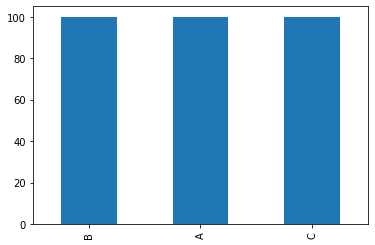

In [125]:
data['Class'].value_counts().plot(kind='bar')

In [126]:
data.shape

(300, 18)

We look at the correlation by looking at the heatmap and pairplot

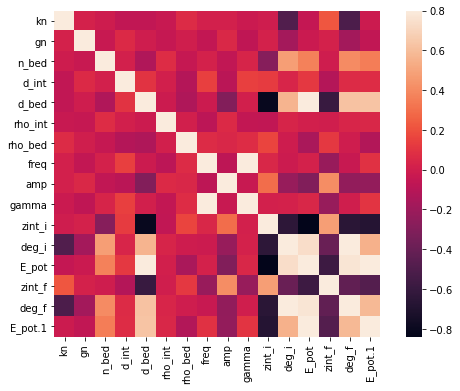

In [127]:
from matplotlib import pyplot as plt
import seaborn as sns

corrmat = data.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True)

In [128]:
#sns.pairplot(data)

From the data lets take the known initial value as feature for training :
- kn and gn : is a physics coefficient
- n_bed : number of grain (small ball)
- d_int : diameter of the intruder (large ball)
- d_bed : diameter of the grain 
- rho_int : density of the intruder
- rho_bed : density of the grain
- freq : frequency of the shake
- amp : amplitudo of shake
- zint_i : intitial position of the intruder

In [129]:
X = data[['kn','gn','n_bed','d_int','d_bed','rho_int','rho_bed','freq','amp','zint_i']]

scaler = preprocessing.StandardScaler()
fit_scale = scaler.fit(X)
X_scaled = fit_scale.transform(X)
X_size = X_scaled.shape[1]

print("Banyak fitur : ", X_size)

Banyak fitur :  10


In [130]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(fit_scale, scaler_filename) 

['scaler.save']

In [131]:
data2 = pd.DataFrame(X_scaled)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data["Class"])
data2["Class"]=le.transform(data.loc[:,"Class"])

In [132]:
order = []
for i in np.unique(data2["Class"]):
    list_temp = []
    for j in range (np.shape(data2)[0]):
        if data2.loc[j,"Class"] == i:
            list_temp.append(data2.loc[j,:])
    order.append(list_temp)
    
neworder = []
for k in range (np.shape(data2)[0]):
    for i in range (np.shape(order)[0]):
        if (np.shape(order[i])[0]) > 0:
            neworder.append(order[i].pop(0))
            
data3 = pd.DataFrame(neworder).reset_index()
data3 = data3.drop(["index"],axis = 1)
data3.head(10)

,0,1,2,3,4,5,6,7,8,9,Class
0,0.229883,1.262589,0.500636,1.539305,-0.196935,1.828516,-1.570777,-0.774800,-1.521825,0.075343,0.0
1,0.729242,1.563231,1.795383,-1.588736,0.165522,-0.462536,-1.242366,-0.582129,1.144603,-1.167733,1.0
2,1.072135,-0.875316,-0.908354,-0.314349,-1.284303,-0.438914,-0.168963,-0.964770,1.144603,2.372222,2.0
3,0.229883,1.262589,0.500636,1.539305,-0.196935,-0.143646,-1.570777,-0.774800,-1.521825,0.075343,0.0
4,0.729242,1.563231,1.795383,-1.588736,0.165522,-0.143646,-1.242366,-0.582129,1.144603,-1.167733,1.0
5,1.122071,1.329398,-1.060677,-1.357029,-0.801028,-0.774838,1.048830,0.185852,-0.215683,1.341440,2.0
6,0.626041,-1.175959,0.805282,-0.777762,-0.317753,-1.131885,0.288299,-0.087848,1.144603,-0.252051,0.0
7,1.148704,-1.008935,0.881444,-0.546056,0.286340,-1.869373,1.179950,-1.563489,-1.310500,-0.973343,1.0
8,1.122071,1.329398,-1.060677,-1.357029,-0.801028,-0.143646,1.048830,0.185852,-0.215683,1.341440,2.0
9,0.626041,-1.175959,0.805282,-0.777762,-0.317753,-0.143646,0.288299,-0.087848,1.144603,-0.252051,0.0


we use K-Fold for cross validation. we only do 4 fold considering how small the data set is

In [133]:
nb_fold = 4
sz_fold = int(np.shape(data3)[0] / nb_fold)

print("Number of testing data : ", sz_fold)
print("Number of train data : ", sz_fold*(nb_fold-1))
print("Total : ", sz_fold*nb_fold )
print("Residu : ", data.shape[0] - sz_fold*nb_fold )

split_data = []
dummy_data = data3
#print(np.shape(dummy_data)[0])

for k in range (nb_fold):
    fold = []
    split_data.append(data3.loc[(k*sz_fold):((k+1)*sz_fold),:])

Number of testing data :  75
Number of train data :  225
Total :  300
Residu :  0


In [134]:
from sklearn.preprocessing import OneHotEncoder

def get_fold(data, k=0):
    data_dummy = list(data)
    test = data_dummy.pop(k)
    #print(test)
    train = pd.concat(data_dummy)
    #print(train)
    
    X_train = train.loc[:,[0,1,2,3,4,5,6,7,8,9]]
    X_test = test.loc[:,[0,1,2,3,4,5,6,7,8,9]]
    
    enc = OneHotEncoder()
    Y_test = enc.fit_transform(test[["Class"]]).toarray()
    Y_train = enc.fit_transform(train[["Class"]]).toarray()

    return X_train, X_test, Y_train, Y_test

In [135]:
uhu = list(data)
testi = uhu.pop(0)
print(testi)

kn


In [136]:
#Y_train

On creating the model here we use Stochastic Gradient Descent with variation in activation function

In [137]:
def build_model(X_size, Y_size,layer = 1, nodes = 1 ):
    opt = SGD(lr=0.001)
    model = Sequential()
    model.add(Dense(nodes, input_dim = X_size, activation = 'sigmoid', use_bias=True))
    model.add(Dropout(0.2))
    if layer != 1:
      for i in range (layer-1):
        model.add(Dense(nodes, activation = 'sigmoid', use_bias=True))
        model.add(Dropout(0.2))   
    model.add(Dense(Y_size, activation = 'softmax'))
    
    # compile model
    model.compile(opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [138]:
#for k in range (nb_fold):
#    X_train, X_test, Y_train, Y_test = get_fold(split_data, k)
#    print(Y_test)

In [103]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 50)                550       
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 3)                 153       
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________


In [142]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.callbacks import TensorBoard
cb = TensorBoard()


def try_model (layer=1, nodes=50):  
  list_acc = []

  for k in range (nb_fold):
      X_train, X_test, Y_train, Y_test = get_fold(split_data, k)

      X_size = np.shape(X_train)[1]
      Y_size = np.shape(Y_train)[1]

      model = build_model(X_size, Y_size, layer=layer,nodes=nodes)

      model.fit(X_train, Y_train,
                              batch_size = 5,
                              epochs = 100,
                              verbose = 0,
                              validation_data = (X_test, Y_test), callbacks = [cb])
      score = model.evaluate(X_test, Y_test, verbose = 0)

      print('Test los [fold : %.2f%%] = ' % (score[0]*100))
      print('Test acc (fold-%.f) : %.2f%%' % (k, score[1]*100))

      list_acc.append(score[1])

  print("mean acc of %.f layer %.f nodes = %.2f%% (+/- %.2f%%)" % (layer, nodes, np.mean(list_acc), np.std(list_acc)))

In here we look at each fold accuracy. we can see how the accuracy different depend on how much layer and how many nodes we use. From here we pick the best number of layer and nodes for the model

In [143]:
%%time
for layer in (1,2):
  for nodes in (1,3,5,10,20,50):
    try_model(layer=layer,nodes=nodes)

Test los [fold : 111.12%] = 
Test acc (fold-0) : 35.53%
Test los [fold : 105.92%] = 
Test acc (fold-1) : 32.89%
Test los [fold : 108.28%] = 
Test acc (fold-2) : 39.47%
Test los [fold : 104.16%] = 
Test acc (fold-3) : 46.67%
mean acc of 1 layer 1 nodes = 0.39% (+/- 0.05%)
Test los [fold : 111.25%] = 
Test acc (fold-0) : 35.53%
Test los [fold : 112.06%] = 
Test acc (fold-1) : 34.21%
Test los [fold : 104.30%] = 
Test acc (fold-2) : 51.32%
Test los [fold : 100.49%] = 
Test acc (fold-3) : 40.00%
mean acc of 1 layer 3 nodes = 0.40% (+/- 0.07%)
Test los [fold : 116.99%] = 
Test acc (fold-0) : 26.32%
Test los [fold : 103.34%] = 
Test acc (fold-1) : 53.95%
Test los [fold : 100.77%] = 
Test acc (fold-2) : 59.21%
Test los [fold : 106.18%] = 
Test acc (fold-3) : 52.00%
mean acc of 1 layer 5 nodes = 0.48% (+/- 0.13%)
Test los [fold : 118.57%] = 
Test acc (fold-0) : 38.16%
Test los [fold : 94.65%] = 
Test acc (fold-1) : 67.11%
Test los [fold : 105.58%] = 
Test acc (fold-2) : 55.26%
Test los [fold : 

In [ ]:
%%time
for layer in (3,4):
  for nodes in (1,3,5,10,20,50):
    try_model(layer=layer,nodes=nodes)

Test los [fold : 109.88%] = 
Test acc (fold-0) : 34.21%
Test los [fold : 109.86%] = 
Test acc (fold-1) : 34.21%
Test los [fold : 109.84%] = 
Test acc (fold-2) : 34.21%
Test los [fold : 109.94%] = 
Test acc (fold-3) : 33.33%
mean acc of 3 layer 1 nodes = 0.34% (+/- 0.00%)
Test los [fold : 109.90%] = 
Test acc (fold-0) : 40.79%
Test los [fold : 110.01%] = 
Test acc (fold-1) : 15.79%
Test los [fold : 109.73%] = 
Test acc (fold-2) : 43.42%
Test los [fold : 109.88%] = 
Test acc (fold-3) : 33.33%
mean acc of 3 layer 3 nodes = 0.33% (+/- 0.11%)
Test los [fold : 109.87%] = 
Test acc (fold-0) : 31.58%
Test los [fold : 109.66%] = 
Test acc (fold-1) : 34.21%
Test los [fold : 109.49%] = 
Test acc (fold-2) : 34.21%
Test los [fold : 109.88%] = 
Test acc (fold-3) : 33.33%
mean acc of 3 layer 5 nodes = 0.33% (+/- 0.01%)
Test los [fold : 110.12%] = 
Test acc (fold-0) : 26.32%
Test los [fold : 109.24%] = 
Test acc (fold-1) : 38.16%
Test los [fold : 109.74%] = 
Test acc (fold-2) : 34.21%
Test los [fold :

After selecting the highest accuracy based on the number of nodes and layer we now add the number of data to get a better result

In [ ]:
data = data.groupby(by = 'Class').head(250)

In [141]:
%%time
layer = 1
nodes = 50

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.callbacks import TensorBoard
cb = TensorBoard()

list_acc = []

for k in range (nb_fold):
    X_train, X_test, Y_train, Y_test = get_fold(split_data, k)
    
    X_size = np.shape(X_train)[1]
    Y_size = np.shape(Y_train)[1]
    
    model = build_model(X_size, Y_size, layer=layer,nodes=nodes)
    
    print(Y_train[2,:])
    print(Y_test[2,:])
    model.fit(X_train, Y_train,
                            batch_size = 5,
                            epochs = 10,
                            verbose = 0,
                            validation_data = (X_test, Y_test), callbacks = [cb])
    print(Y_train[2,:])
    print(Y_test[2,:])
    score = model.evaluate(X_test, Y_test, verbose = 0)
    
    #print('Test los [fold : %.2f%%] = ' % (score[0]*100))
    print('Test acc (fold-%.f) : %.2f%%' % (k, score[1]*100))
    
    list_acc.append(score[1])
    
print("mean acc of %.f layer %.f nodes = %.2f%% (+/- %.2f%%)" % (layer, nodes, np.mean(list_acc), np.std(list_acc)))

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
Test acc (fold-0) : 36.84%
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
Test acc (fold-1) : 30.26%
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
Test acc (fold-2) : 50.00%
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
Test acc (fold-3) : 38.67%
mean acc of 1 layer 50 nodes = 0.39% (+/- 0.07%)
CPU times: user 7.59 s, sys: 289 ms, total: 7.88 s
Wall time: 7.33 s


In [ ]:
from keras.callbacks import TensorBoard

cb = TensorBoard()

layer = 1
nodes = 50

X_train, X_test, Y_train, Y_test = get_fold(split_data, 1)

X_size = np.shape(X_train)[1]
Y_size = np.shape(Y_train)[1]

model = build_model(X_size, Y_size, layer=layer,nodes=nodes)

history_callback = model.fit(X_train, Y_train,
                          batch_size = 5,
                          epochs = 100,
                          verbose = 0,
                          validation_data = (X_test, Y_test), callbacks = [cb])
score = model.evaluate(X_test, Y_test, verbose = 0)

import matplotlib.pyplot as plt
% matplotlib inline

fig, (ax1,ax2) = plt.subplots(2, figsize = (8,6))

acc = history_callback.history['accuracy']
loss = history_callback.history['loss']
val_acc = history_callback.history['val_accuracy']
val_loss = history_callback.history['val_loss']
ax1.plot(acc, label='train')
ax1.plot(val_acc, label='test')
ax2.plot(loss, label='train')
ax2.plot(val_loss, label='test')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')

ax1.legend()
ax2.legend()
plt.show()

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
for i in range (np.shape(acc)[0]):
  print(acc[i], val_acc[i])

Pred 	 Actual 	 Conclusion
B 	 B 		 True
C 	 C 		 True
A 	 A 		 True
A 	 B 		 False
C 	 C 		 True
A 	 A 		 True
B 	 B 		 True
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
B 	 B 		 True
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
A 	 A 		 True
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
A 	 A 		 True
B 	 B 		 True
C 	 C 		 True
A 	 A 		 True
A 	 B 		 False
C 	 C 		 True
A 	 A 		 True
A 	 B 		 False
C 	 C 		 True
A 	 A 		 True
B 	 B 		 True
C 	 C 		 True
A 	 A 		 True
B 	 B 		 True
C 	 C 		 True
A 	 A 		 True
B 	 B 		 True
C 	 C 		 True
B 	 A 		 False
B 	 B 		 True
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
A 	 B 		 False
C 	 C 		 True
B 	 A 		 False
B 	 B 		 True
C 	 C 		 True
A 	 A 		 True
B 	 B 		 True
C 	 C 		 True
B 	 A 		 False
B 	 B 		 True
C 	 C 		 Tr

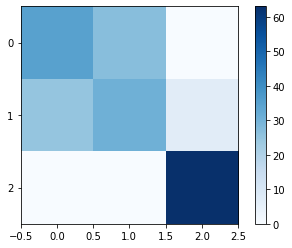

In [217]:
pred_test = np.argmax(model.predict(X_test),axis=1)
act_test = np.argmax(Y_test, axis=1)

n = 0

    
def backtoclass(value):
    if value == 0:
        return 'A'
    elif value == 1:
        return 'B'
    elif value == 2:
        return 'C'


print('Pred \t Actual \t Conclusion')
for i in range (pred_test.shape[0]):
    print(backtoclass(pred_test[i]),
          "\t", 
          backtoclass(act_test[i]),
          "\t\t",
          'True' if pred_test[i] == act_test[i] else 'False')
    if pred_test[i] == act_test[i]: n=n+1
    
print('\n Prediksi benar = ', n, ', dari jumlat uji = ', pred_test.shape[0])


from sklearn.metrics import classification_report, confusion_matrix
#import seaborn as sns


print(classification_report(act_test, pred_test)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(act_test, pred_test)
print(cm)

df_cm = pd.DataFrame(cm)
#heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.imshow(df_cm, cmap='Blues', interpolation='nearest')
ticks=np.arange(0,3)
plt.yticks(ticks)
plt.colorbar()
plt.show()

In [218]:
for i in range (np.shape(acc)[0]):
  print(loss[i], val_loss[i])

1.1868752241134644 1.1076431274414062
1.1528096199035645 1.094113826751709
1.1243329048156738 1.088570237159729
1.1228057146072388 1.0863031148910522
1.1352064609527588 1.0850578546524048
1.1681289672851562 1.0840604305267334
1.1335068941116333 1.083074688911438
1.118509292602539 1.0821999311447144
1.1300932168960571 1.081154227256775
1.1229993104934692 1.0802781581878662
1.1478586196899414 1.0794342756271362
1.1246414184570312 1.0786200761795044
1.1181492805480957 1.0776478052139282
1.1256872415542603 1.076650619506836
1.1370275020599365 1.0758646726608276
1.1133617162704468 1.0749192237854004
1.1301395893096924 1.074012279510498
1.1563421487808228 1.0730150938034058
1.130778193473816 1.0721986293792725
1.1212100982666016 1.0713293552398682
1.125584602355957 1.0705056190490723
1.0996252298355103 1.0696355104446411
1.1239467859268188 1.068726658821106
1.1207773685455322 1.0679078102111816
1.1069389581680298 1.0670005083084106
1.1135872602462769 1.0659655332565308
1.092982530593872 1.06

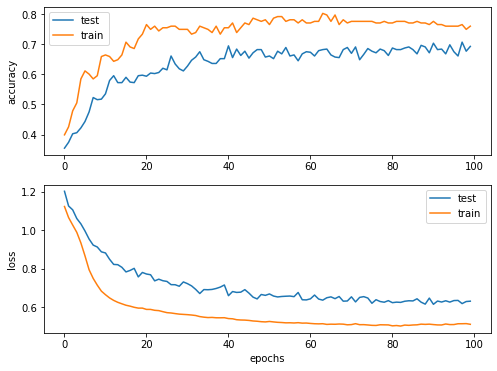

Test loss: 0.5100796222686768
Test accuracy: 0.7606382966041565


In [219]:
def build_model_noDO(layer = 1, nodes = 1 ):
    opt = Adam(lr=0.001)
    model = Sequential()
    model.add(Dense(nodes, input_dim = X_size, activation = 'relu', use_bias=True))
    model.add(Dropout(0.2))
    for i in range (layer-1):
        model.add(Dense(nodes, activation = 'relu', use_bias=True))
        model.add(Dropout(0.2))   
    model.add(Dense(Y_size, activation = 'softmax'))
    
    # compile model
    model.compile(opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model


from keras.callbacks import TensorBoard

cb = TensorBoard()

layer = 2
nodes = 50

X_train, X_test, Y_train, Y_test = get_fold(split_data, 2)

X_size = np.shape(X_train)[1]
Y_size = np.shape(Y_train)[1]

model = build_model_noDO(layer=2,nodes=5)

history_callback = model.fit(X_train, Y_train,
                          batch_size = 5,
                          epochs = 100,
                          verbose = 0,
                          validation_data = (X_test, Y_test), callbacks = [cb])
score = model.evaluate(X_test, Y_test, verbose = 0)

import matplotlib.pyplot as plt
% matplotlib inline

fig, (ax1,ax2) = plt.subplots(2, figsize = (8,6))

acc = history_callback.history['accuracy']
loss = history_callback.history['loss']
val_acc = history_callback.history['val_accuracy']
val_loss = history_callback.history['val_loss']
ax1.plot(acc, label='test')
ax1.plot(val_acc, label='train')
ax2.plot(loss, label='test')
ax2.plot(val_loss, label='train')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('loss')
ax2.set_xlabel('epochs')

ax1.legend()
ax2.legend()
plt.show()

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
for i in range (np.shape(acc)[0]):
  print(acc[i], val_acc[i])

In [221]:
for i in range (np.shape(acc)[0]):
  print(loss[i], val_loss[i])

1.2021760940551758 1.1228857040405273
1.125523328781128 1.0654757022857666
1.1056121587753296 1.026485562324524
1.0604594945907593 0.9884703755378723
1.032636046409607 0.9334498643875122
0.995564341545105 0.8661320209503174
0.9537332057952881 0.793875515460968
0.9221702218055725 0.7489087581634521
0.912209153175354 0.7137140035629272
0.887189507484436 0.6825482845306396
0.8812126517295837 0.6639900207519531
0.8483448624610901 0.647243320941925
0.8216397166252136 0.634401261806488
0.8202052116394043 0.6243959069252014
0.8065618276596069 0.6166625618934631
0.7825661301612854 0.6092287302017212
0.790283739566803 0.6044954061508179
0.8011354207992554 0.5985101461410522
0.7567108273506165 0.5942968130111694
0.7797322273254395 0.5942655801773071
0.7716920971870422 0.5875161290168762
0.7679036259651184 0.5874623656272888
0.7360559105873108 0.5828761458396912
0.7447498440742493 0.5812170505523682
0.7367662191390991 0.5757331252098083
0.7330660820007324 0.5706685781478882
0.7163485288619995 0.5